In [1]:
import pandas as pd
import numpy as np
import os 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
from IPython.display import display, HTML

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '../../../openAi/TS_analysis_TOPIC9/'))

In [3]:
from pyts_utils import descriptive_tools
from pyts_utils import proximity_tools
from cdlib import algorithms, ensemble,evaluation
from cdlib import viz
from sklearn.metrics import pairwise_distances

In [4]:
af_ex_pca = pd.read_csv('af_ex_pca.csv',index_col=0)

In [581]:
pivot_afex=af_ex_pca.pivot_table(values='af_ex_pca',columns='country',index='year')
pivot_afex=pivot_afex.drop(columns='Unspecified Area')
pivot_afex = pivot_afex.dropna(axis=1,thresh=20)

Clusters of antifragility time series (one series for each country from 1987 to 2017) were found considering euclidean distance as proximity measure (dissimilarity). An $\epsilon$-NN network was constructed setting $\epsilon = 2.8$ to connect pairs of nodes representing time series of antifragility with less than $\epsilon$ euclidean distance. I ignored the null values at the moment of computing the distances. Then I applied greedy_modularity and louvain community detection algorithms. 3 communities that minimize modularity were found by both algorithms. Averaging the antifragility time series of countries in each community, it can be seen that they represent antifragile, robust, and fragile groups of countries over time. I also calculated the adjusted rand index(ARI) and adjusted mutual information(AMI) to check the similarity between the communities found by each algorithm.

Below is a plot of the network and AMI and ARI estimations. Then, I show some plots that relate the groups of countries and other variables, specifically gdp, population, and sum of distances of exportations and importations.

In [582]:
# Distance_matrix = 1 - abs(pivot_afex.corr())
Distance_matrix = pd.DataFrame(pairwise_distances(pivot_afex.T,metric='nan_euclidean'),index=pivot_afex.columns,columns=pivot_afex.columns)

In [595]:
## ϵ-NN network construction
ϵ = 3

epsilon_NN = Distance_matrix[Distance_matrix < ϵ]
epsilon_NN = epsilon_NN.fillna(0)

In [596]:
G = nx.Graph()
for country1,series in epsilon_NN.iteritems():
    for country2,proximity in series.iteritems():
        if not np.equal(proximity,0):  
            G.add_edge(country1,country2)

In [597]:
#Greedy_modul
comm_greedy = algorithms.greedy_modularity(G)

# louvain
communities = algorithms.louvain(G)

ARI and AMI range from 0 to 1. Values close to 1 indicate that two different clustering results are similar in terms of objects belonging to the same groups in both cluster results.

In [598]:
print("ARI:",communities.adjusted_rand_index(comm_greedy).score)

ARI: 0.37617210057696904


In [599]:
print('AMI:',communities.adjusted_mutual_information(comm_greedy).score)

AMI: 0.40738270476626365


In [600]:
print('Number of communities found by louvan and greedy modularity community detection algorithms:',len(communities.communities))

Number of communities found by louvan and greedy modularity community detection algorithms: 3


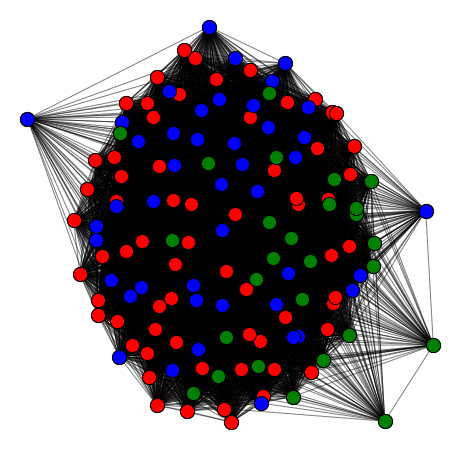

In [601]:
_=viz.plot_network_clusters(G,communities)

In [602]:
indices = [ index for index,group in enumerate(communities.communities) for count in group ]
countries = [c for g in communities.communities for c in g]

In [603]:
df_communities = pd.DataFrame(data=np.c_[countries,indices],columns=['country','labels'])

In [575]:
df_communities.to_excel('cluster.xlsx')

In [604]:
mergd_afex_communities = pivot_afex.T.merge(df_communities,on='country')

The following plot shows that, considering medians (this is to have a more robust estimator of centrality, so that patterns were not drastically affected by potential outliers), countries belonging to group 0 have positive antifragility values over time, group 1 is mostly negative, particulary from 2006 to 2017, and group 3 is generally close to 0 most of the time, so robust.

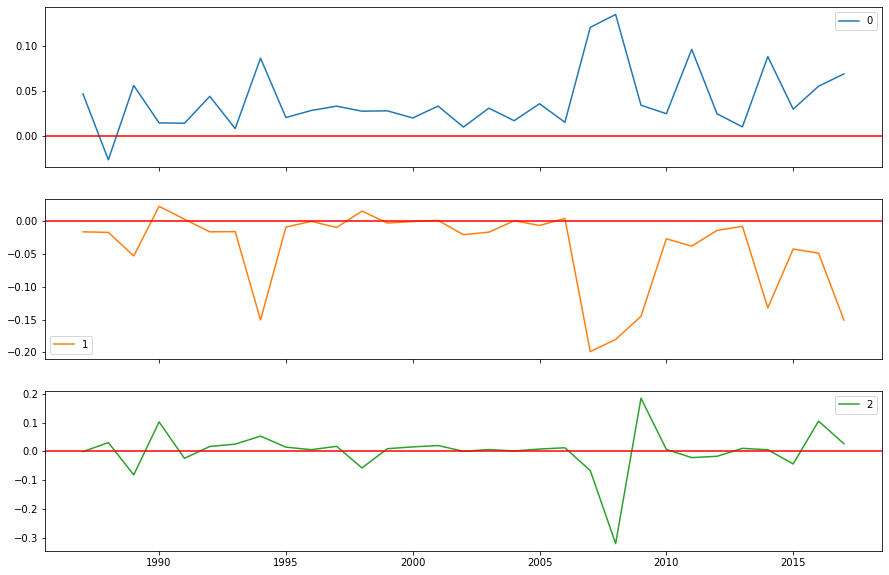

In [606]:
ax=mergd_afex_communities.groupby('labels').median().T.plot(subplots=True,figsize=(15,10))
for a in ax:
    a.axhline(0,c='red')

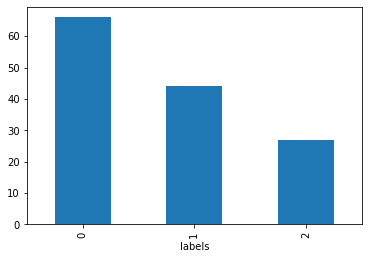

In [608]:
_=(mergd_afex_communities.groupby('labels').count()['country']).plot.bar() # Number of countries per community

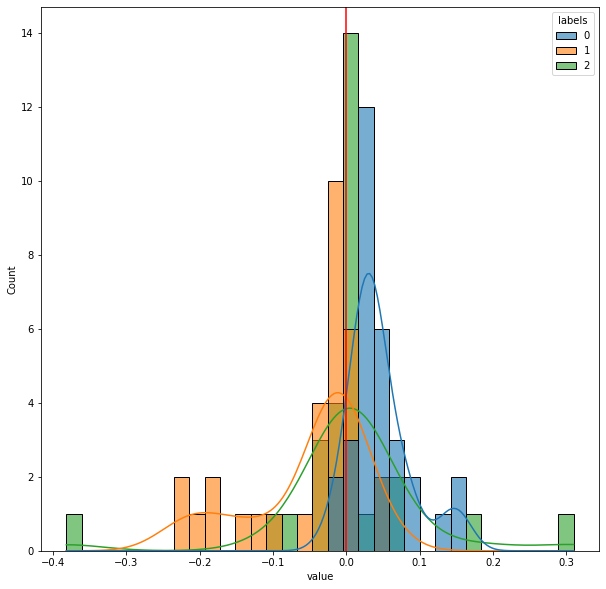

In [610]:
plt.figure(figsize=(10,10))
sns.histplot(x='value',data=mergd_afex_communities.groupby('labels').mean().T.melt(),hue='labels',kde=True,alpha=0.6)
plt.axvline(0,c='red')

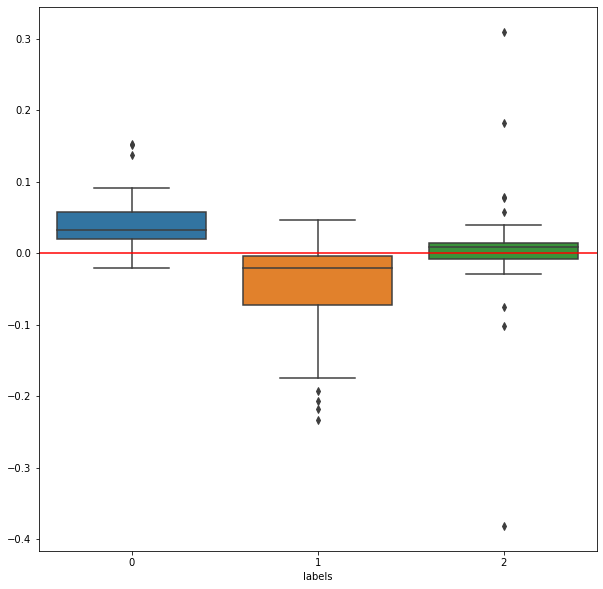

In [611]:
plt.figure(figsize=(10,10))
sns.boxplot(data=mergd_afex_communities.groupby('labels').mean().T)
plt.axhline(0,c='red')

Below is the share of countries per group

In [245]:
pop=pd.read_csv('pairing_data/Population_clean.csv',index_col=0)
gdp = pd.read_csv('pairing_data/GDP_clean.csv',index_col=0)
distance = pd.read_csv('pairing_data/for_distance_pairing/distances_year_ex_im.csv',index_col=0) # distances in Km

merged_pop_communities = pop.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_gdp_communities = gdp.merge(df_communities,how='inner',left_on='country.value',right_on='country').drop(columns='country.value',axis=1)
merged_pop_communities = merged_pop_communities[['date','value','country','labels']]
merged_gdp_communities = merged_gdp_communities[['date','value','country','labels']]

merged_distances_ex_communities = distance.groupby(['exporter','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='exporter',right_on='country').drop(columns='exporter',axis=1)
merged_distances_in_communities = distance.groupby(['importer','Year']).sum().reset_index().merge(df_communities,how='inner',left_on='importer',right_on='country').drop(columns='importer',axis=1)

### Time series of mean gdp/pop per group

<AxesSubplot:xlabel='date', ylabel='value'>

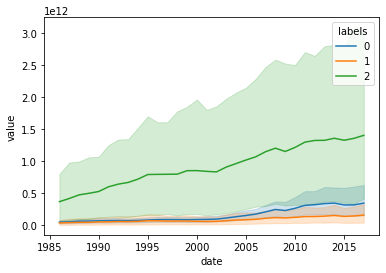

In [285]:
sns.lineplot(data=merged_gdp_communities,y='value',x='date',hue='labels',hue_order=['0','1','2'])

<AxesSubplot:xlabel='date', ylabel='value'>

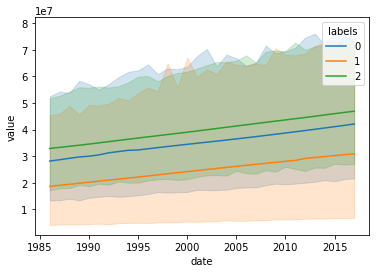

In [286]:
sns.lineplot(data=merged_pop_communities[['date','value','country','labels']],y='value',x='date',hue='labels',hue_order=['0','1','2'])

### Distribution of mean gdp per group over time

<AxesSubplot:xlabel='value', ylabel='Count'>

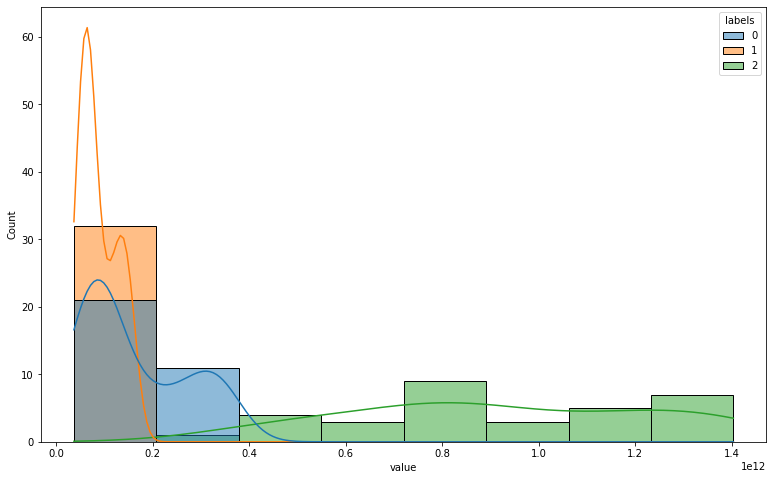

In [181]:
fig,axs=plt.subplots(1,1,figsize=(13,8))
sns.histplot(x='value',data=merged_gdp_communities.groupby(['date','labels']).mean().reset_index(),hue='labels',kde=True,ax=axs)

### Time series of means of sum of distances whuch are computed between one country and each of the countries to which this country exported food.

<AxesSubplot:xlabel='Year', ylabel='distance'>

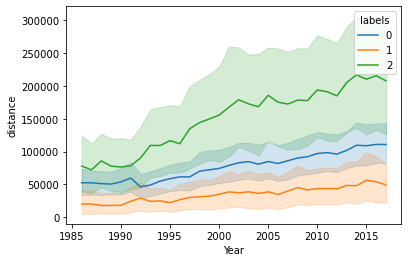

In [264]:
sns.lineplot(data=merged_distances_ex_communities,y='distance',x='Year',hue='labels',hue_order=['0','1','2'])

<AxesSubplot:xlabel='Year', ylabel='distance'>

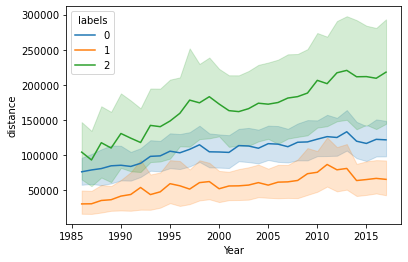

In [263]:
sns.lineplot(data=merged_distances_in_communities,y='distance',x='Year',hue='labels',hue_order=['0','1','2'])

### Distribution of means (per group over time) of sum of distances (same as above with time series)  

<AxesSubplot:xlabel='distance', ylabel='Count'>

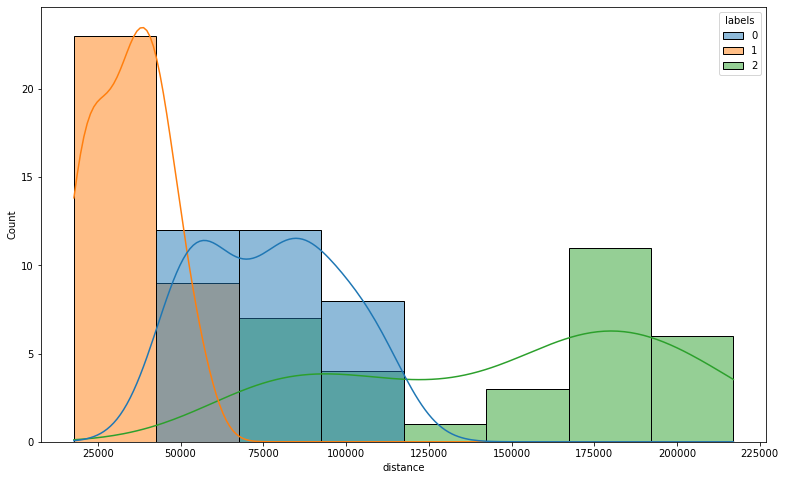

In [211]:
fig,axs=plt.subplots(1,1,figsize=(13,8))
sns.histplot(x='distance',data=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index(),hue='labels',kde=True,ax=axs)

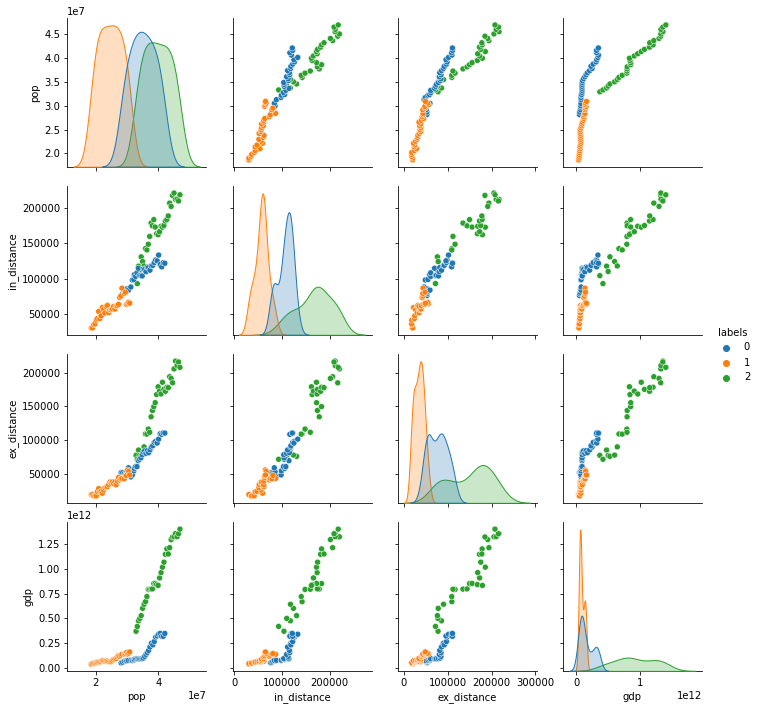

In [146]:
Matrix_merged_communities = merged_pop_communities.groupby(['date','labels']).mean().reset_index().rename(columns={'value':'pop'})
Matrix_merged_communities['in_distance']=merged_distances_in_communities.groupby(['Year','labels']).mean().reset_index()['distance']
Matrix_merged_communities['ex_distance']=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index()['distance']
Matrix_merged_communities['gdp'] = merged_gdp_communities.groupby(['date','labels']).mean().reset_index()['value']

sns.pairplot(data=Matrix_merged_communities.iloc[:,1:],hue='labels')

<AxesSubplot:>

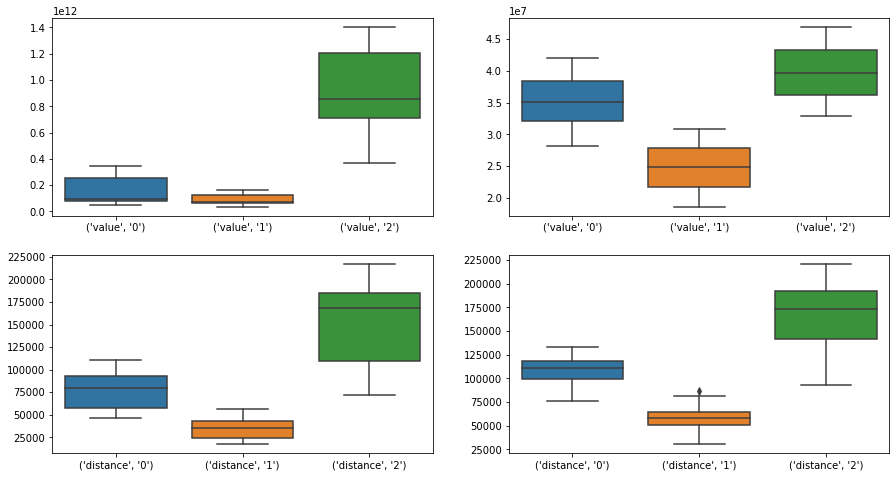

In [300]:
fig,axs=plt.subplots(2,2,figsize=(15,8))
sns.boxplot(data=merged_gdp_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,0])
sns.boxplot(data=merged_pop_communities.groupby(['date','labels']).mean().reset_index().pivot_table(index='date',columns='labels'),ax=axs[0,1])
sns.boxplot(data=merged_distances_ex_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,0])
sns.boxplot(data=merged_distances_in_communities.groupby(['Year','labels']).mean().reset_index().pivot_table(index='Year',columns='labels'),ax=axs[1,1])